In [101]:
# import

import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import glob
import pickle
import time
import math
import datetime

import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from numpy.random import permutation
from keras.models import Sequential
from keras.layers.core import Dense
from keras.applications import VGG16
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")


In [102]:
# constants

CACHE_PATH = "../cache"
INPUT_PATH = "../input"
SUBMISSIONS_PATH = '../submissions'

TRAIN_DATA_PATH = os.path.join(INPUT_PATH, "imgs/train")
TEST_DATA_PATH = os.path.join(INPUT_PATH, "imgs/test")

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

CLASSES_COUNT = 10

USE_CACHE = True
CACHE_MAX_BYTES = 2 ** 31 - 1  # is used for storing big files
CACHE_TRAIN_DATA_PATH = os.path.join(CACHE_PATH, "train_data.dat")
CACHE_TEST_DATA_PATH = os.path.join(CACHE_PATH, "test_data.dat")

MEAN_PIXELS = [103.939, 116.779, 123.68]


In [103]:
# project setting

if not os.path.isdir(CACHE_PATH):
    os.mkdir(CACHE_PATH)

if not os.path.isdir(INPUT_PATH):
    os.mkdir(INPUT_PATH)
    
if not os.path.isdir(SUBMISSIONS_PATH):
    os.mkdir(SUBMISSIONS_PATH)


In [108]:
# utils

def get_image(path):
    image = cv2.imread(path)
    return image

def get_resized_image(path):
    image = get_image(path)
    resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_LINEAR)
    return resized_image

def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesn\'t exists')
        
def cache_big_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        bytes_out = pickle.dumps(data)
        with open(path, 'wb') as f_out:
            for idx in range(0, len(bytes_out), CACHE_MAX_BYTES):
                f_out.write(bytes_out[idx:idx+CACHE_MAX_BYTES])
    else:
        print('Directory doesn\'t exists')

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    else:
        print('File doesn\'t exists')
    return data

def restore_big_data(path):
    data = dict()
    if os.path.isfile(path):
        bytes_in = bytearray(0)
        input_size = os.path.getsize(path)
        with open(path, 'rb') as f_in:
            for _ in range(0, input_size, CACHE_MAX_BYTES):
                bytes_in += f_in.read(CACHE_MAX_BYTES)
        data = pickle.loads(bytes_in)
    else:
        print('File doesn\'t exists')
    return data

def save_model(model):
    model_json_string = model.to_json()
    open(os.path.join(CACHE_PATH, 'model_architecture_vgg16.json'), 'w').write(model_json_string)
    model.save_weights(os.path.join(CACHE_PATH, 'model_weights_vgg16.h5'), overwrite=True)

def read_model():
    model = model_from_json(open(os.path.join(CACHE_PATH, 'model_architecture_vgg16.json')).read())
    model.load_weights(os.path.join(CACHE_PATH, 'model_weights_vgg16.h5'))
    return model


In [110]:
# task specific functions

def get_driver_data():
    """
    Aggregate data for training
    :return: 
        driver_data: dict
            {
                "image path": "driver string",
                ...
            }  
    """
    driver_data = dict()
    path = os.path.join(INPUT_PATH, 'driver_imgs_list.csv')

    print('Read drivers data')
    f = open(path, 'r')

    # skip header
    f.readline()

    while True:
        row = f.readline()       
        if row == '':
            break

        row_arr = row.strip().split(',')
        driver = row_arr[0]
        image = row_arr[2]

        driver_data[image] = driver
    
    f.close()

    return driver_data

def get_train_data():
    X_train = []
    y_train = []

    X_train_id = []
    driver_id = []

    print('Read train images ...')
    start_time = time.time()
    driver_data = get_driver_data()

    for c in range(CLASSES_COUNT):
        class_folder = f'c{c}'
        
        print(f'Load folder {class_folder}')
        path = os.path.join(TRAIN_DATA_PATH, class_folder, '*.jpg')
        images = glob.glob(path)

        for image_path in images:
            image = get_resized_image(image_path)

            X_train.append(image)
            y_train.append(c)

            image_name = os.path.basename(image_path)
            X_train_id.append(image_name)
            driver_id.append(driver_data[image_name])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))

    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers count: {}'.format(len(unique_drivers)))
    print(unique_drivers)

    return X_train, y_train, X_train_id, driver_id, unique_drivers

def get_test_data():
    X_test = []
    X_test_id = []

    print('Read test images ...')
    start_time = time.time()
 
    path = os.path.join(TEST_DATA_PATH, '*.jpg')
    images = glob.glob(path)
    
    images_count = len(images)
    step = math.floor(images_count / 10)
    total = 0

    for image_path in images:
        image = get_resized_image(image_path)

        X_test.append(image)

        image_name = os.path.basename(image_path)
        X_test_id.append(image_name)
        
        total += 1
        if total % step == 0:
            print('Read {} images from {}'.format(total, images_count))

    print('Read test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    print('Total images: {}'.format(total))

    return X_test, X_test_id

def read_and_process_train_data():
    print('Train data processing start')
    start_time = time.time()

    if not os.path.isfile(CACHE_TRAIN_DATA_PATH) or not USE_CACHE:
        train_data, train_target, train_id, driver_id, unique_drivers = get_train_data()
        cache_big_data(
            (train_data, train_target, train_id, driver_id, unique_drivers), 
            CACHE_TRAIN_DATA_PATH
        )
    else:
        print('Restore train data from cache')
        (train_data, train_target, train_id, driver_id, unique_drivers) = restore_big_data(CACHE_TRAIN_DATA_PATH)

    print('Convert data to numpy array')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    print('Normalize data')
    train_data = train_data.astype('float32')
    for channel in range(3):
        print('Normalize data for channel {}'.format(channel))
        train_data[:, :, :, channel] = train_data[:, :, :, channel] - MEAN_PIXELS[channel]

    print('Convert labels to categorical')
    train_target = np_utils.to_categorical(train_target, 10)

    print('Shuffle data')
    perm = permutation(len(train_target))
    train_data = train_data[perm]
    train_target = train_target[perm]

    print('Train data processing end: {} seconds'.format(round(time.time() - start_time, 2)))

    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')

    return train_data, train_target, driver_id, unique_drivers

def read_and_process_test_data():
    print('Test data processing start')
    start_time = time.time()

    if not os.path.isfile(CACHE_TEST_DATA_PATH) or not USE_CACHE:
        test_data, test_id = get_test_data()
        cache_big_data(
            (test_data, test_id), 
            CACHE_TEST_DATA_PATH
        )
    else:
        print('Restore test data from cache')
        (test_data, test_id) = restore_big_data(CACHE_TEST_DATA_PATH)

    print('Convert data to numpy array')
    test_data = np.array(test_data, dtype=np.uint8)

    print('Normalize data')
    test_data = test_data.astype('float32')
    for channel in range(3):
        print('Normalize data for channel {}'.format(channel))
        test_data[:, :, :, channel] = test_data[:, :, :, channel] - MEAN_PIXELS[channel]

    print('Test data processing end: {} seconds'.format(round(time.time() - start_time, 2)))

    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')

    return test_data, test_id

def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 
                                                'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    now = datetime.datetime.now()
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join(SUBMISSIONS_PATH, 'submission_' + suffix + '.csv')
    result.to_csv(sub_file, index=False)


In [111]:
# model configuration

def get_model():
    vgg_16 = VGG16()
    model = Sequential()
    
    # not including last layer
    for index, layer in enumerate(vgg_16.layers[:-1]):
        model.add(layer)
        
        # freeze first 15 layers
        if index < 15:
            layer.trainable = False

    # add classification layer
    model.add(Dense(CLASSES_COUNT, activation='softmax'))

    optimizer = SGD(
        lr=1e-3, 
        decay=1e-6, 
        momentum=0.9, 
        nesterov=True
    )
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy',
        metrics=["accuracy"]
    )

    return model


In [ ]:
# driver_id and unique_drivers are not used in current implementation without KFold using
train_data, train_target, driver_id, unique_drivers = read_and_process_train_data()


Train data processing start
Read train images ...
Read drivers data
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 95.32 seconds
Unique drivers count: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert data to numpy array
Normalize data
Normalize data for channel 0
Normalize data for channel 1
Normalize data for channel 2
Convert labels to categorical
Shuffle data
Train data processing end: 754.62 seconds
Train shape: (22424, 224, 224, 3)
22424 train samples


In [ ]:
# train model

nb_epoch = 5
batch_size = 16
split = 0.2

model = get_model()
model.fit(
    train_data, 
    train_target, 
    nb_epoch=nb_epoch,
    batch_size=batch_size,
    validation_split=split,
    verbose=1, shuffle=True
)

save_model(model)


INFO:plaidml:Opening device "metal_amd_radeon_pro_560.0"


Train on 17939 samples, validate on 4485 samples
Epoch 1/5


INFO:plaidml:Analyzing Ops: 77 of 324 operations complete
INFO:plaidml:Analyzing Ops: 192 of 324 operations complete


17936/17939 [============================>.] - ETA: 0s - loss: 0.2026 - acc: 0.9348

INFO:plaidml:Analyzing Ops: 76 of 324 operations complete
INFO:plaidml:Analyzing Ops: 192 of 324 operations complete
INFO:plaidml:Analyzing Ops: 61 of 193 operations complete
INFO:plaidml:Analyzing Ops: 118 of 193 operations complete
INFO:plaidml:Analyzing Ops: 71 of 193 operations complete
INFO:plaidml:Analyzing Ops: 136 of 193 operations complete


17939/17939 [==============================] - 2501s 139ms/step - loss: 0.2025 - acc: 0.9348 - val_loss: 0.0393 - val_acc: 0.9904
Epoch 2/5
17939/17939 [==============================] - 3137s 175ms/step - loss: 0.0181 - acc: 0.9943 - val_loss: 0.0321 - val_acc: 0.9918
Epoch 3/5
17939/17939 [==============================] - 2670s 149ms/step - loss: 0.0049 - acc: 0.9985 - val_loss: 0.0285 - val_acc: 0.9926
Epoch 4/5
17939/17939 [==============================] - 2862s 160ms/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0180 - val_acc: 0.9960
Epoch 5/5
17939/17939 [==============================] - 2777s 155ms/step - loss: 1.8878e-04 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9969


In [21]:
# get test data

test_data, test_id = read_and_process_test_data()


Test data processing start
Read test images ...
Read 7972 images from 79726
Read 15944 images from 79726
Read 23916 images from 79726
Read 31888 images from 79726
Read 39860 images from 79726
Read 47832 images from 79726
Read 55804 images from 79726
Read 63776 images from 79726
Read 71748 images from 79726
Read 79720 images from 79726
Read test data time: 371.35 seconds
Total images: 79726
Convert data to numpy array
Normalize data
Normalize data for channel 0
Normalize data for channel 1
Normalize data for channel 2
Test data processing end: 3331.83 seconds
Test shape: (79726, 224, 224, 3)
79726 test samples


In [33]:
# get predictions based on test_data

predictions = model.predict(test_data, verbose=1)


INFO:plaidml:Analyzing Ops: 83 of 161 operations complete


79712/79726 [============================>.] - ETA: 0s

INFO:plaidml:Analyzing Ops: 61 of 161 operations complete
INFO:plaidml:Analyzing Ops: 126 of 161 operations complete


79726/79726 [==============================] - 3847s 48ms/step


In [112]:
# create submission

create_submission(predictions, test_id, "v1")


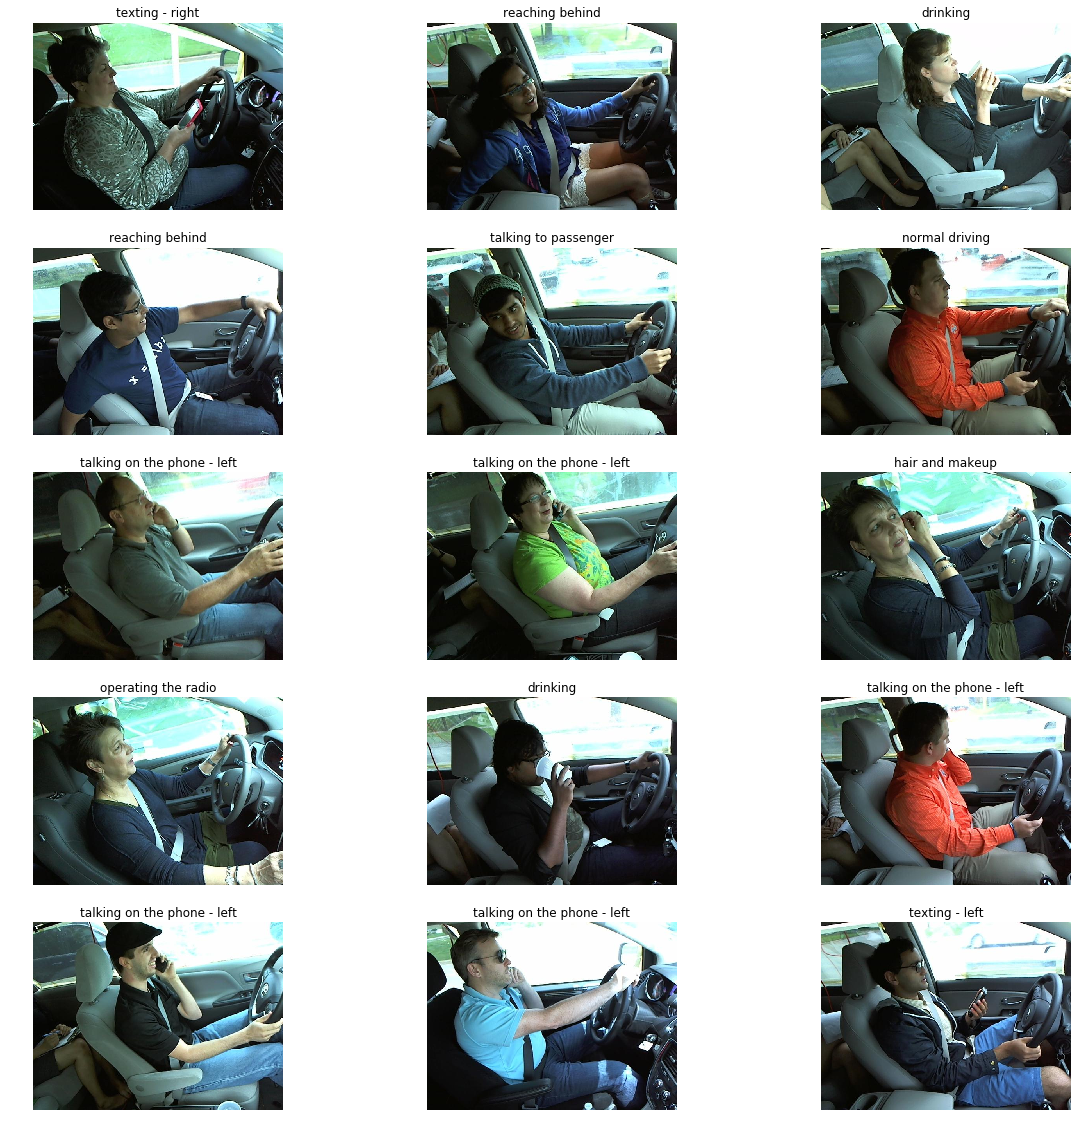

In [115]:
# show results

labels = {
    'c0': 'normal driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger',
}

fig = plt.figure(figsize=(20, 20))
columns = 3
rows = 5

arr_offset = 200
p_arr = predictions[arr_offset:arr_offset+columns*rows]

for i, p in enumerate(p_arr):
    label = f'c{p.argmax()}'
    title = labels[label]
    fig.add_subplot(rows, columns, i+1, title=title)

    img = get_image(os.path.join(TEST_DATA_PATH, test_id[arr_offset+i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis('off')
    plt.imshow(img)
